In [1]:
import sqlite3
con = sqlite3.connect('mydb.db') 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read the file and store in dataframe.
data = pd.read_csv('06-27_LG-dati-alberi.csv') 

#keep useful column related to the tree conditon 
data = data[['Plot','ID','Survey Date', 'Species', 'DBH 1 (cm)', 'Crown: Condition', 'Total Height (m)']]
data.columns = ['plot', 'id', 'survey_date', 'species',  'dbh_1', 'crown_condition', 'total_height']

#convert the date type and check
data['survey_date']=pd.to_datetime(data['survey_date'])
data.head()

,plot,id,survey_date,species,dbh_1,crown_condition,total_height
0,1,1,2021-06-21,European hackberry (Celtis australis),66.8,90% - 95%,21.0
1,1,2,2021-06-21,European hackberry (Celtis australis),57.3,70% - 75%,22.0
2,1,3,2021-06-21,European hackberry (Celtis australis),63.7,65% - 70%,20.0
3,1,4,2021-06-21,Sweet cherry (Prunus avium),7.6,100%,8.0
4,1,5,2021-06-21,Sweet cherry (Prunus avium),8.9,100%,8.0


In [4]:
#store in the database

data.to_sql(name='LG_06_data',con = con,if_exists="replace")

### According to the division of our group, I am responsible for the correlation analysis of 'Crown: Condition'. 

In [5]:
# Count samples numbers according to crown condition
sql="""
    select crown_condition as crown,count(*) as n_samples
    from LG_06_data
    group by crown
    order by crown desc
    ;
"""
# pd.set_option('display.max_columns',None).# I found sql print is not restrict by only 5 lines.
pd.read_sql(sql,con)

,crown,n_samples
0,95% - 99%,33
1,90% - 95%,65
2,85% - 90%,69
3,80% - 85%,31
4,75% - 80%,42
5,70% - 75%,27
6,65% - 70%,13
7,60% - 65%,14
8,55% - 60%,11
9,50% - 55%,10


First, there are two types of data, one is interval, the other is 100% and 0%. In order to unify the format, I will take the upper limit of the interval when drawing later. Secondly, from the table, the crown of most trees is in good condition, with a total of 509 trees, more than 90% of which have a crown coverage of more than 70%. We see that the number of trees with a coverage of 100% is the largest, and more than 60% of the trees have a crown coverage of 90%.

### Next step, I checked and visualized the column of  species , DBH1 and total height, which I thought might be related to crown condition.

#### First I check the date. I found they were all collected from June and one tree once. So it don't include time-related change.

In [6]:
#Check the date,sort according to the number from large to small
sql="""
    select date(survey_date) as survey_date,plot,count(*) as n_samples
    from LG_06_data
    group by survey_date
    order by n_samples desc
    ;
"""
pd.read_sql(sql,con)

,survey_date,plot,n_samples
0,2021-06-21,1,280
1,2021-06-23,9,96
2,2021-06-25,7,67
3,2021-06-19,5,41
4,2021-06-26,7,22
5,2021-06-20,14,3


### DBH1 and crown.

Text(0.5, 1.0, 'DBH1 vs Crown')

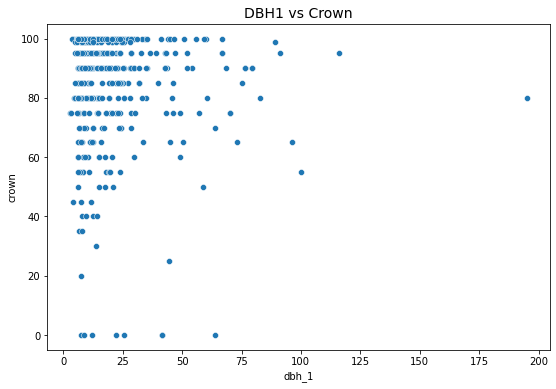

In [7]:
sql="""
select dbh_1,crown_condition
,cast(case 
        when instr(crown_condition,'-')>0 then substr(crown_condition,instr(crown_condition,'-')+2,2)
        else substr(crown_condition,1,3)
        end as float) as crown
from LG_06_data
    ;
"""

df_dbh_crown=pd.read_sql(sql,con)

plt.figure(figsize=(9,6))
sns.scatterplot(y='crown',x="dbh_1",data=df_dbh_crown)
# plt.xlim(55,105)
plt.title("DBH1 vs Crown",fontsize=14)

It looks a little positive correlative. The reason why we need to consider the DBH1 and crown is to reflect the health and value of the tree. DBH of trees is used to describe the diameter and size of trees, which is a very important data in the biological measurement of trees. When assessing the impact of trees on the environment, we need to consider their carbon sequestration and carbon dioxide absorption. Trunk (dbh1 calculation) and crown are the key to calculate carbon sequestration. 


The larger the amount of dbh1 and crown data, the higher the biomass of this tree, which can fix more carbon and generate more economic value. As for the amount of carbon dioxide that can be absorbed, I think it is more related to tree species, so the analysis here is currently used to discuss the amount of carbon sequestration.

### Height and crown.

Text(0.5, 1.0, 'Height vs Crown')

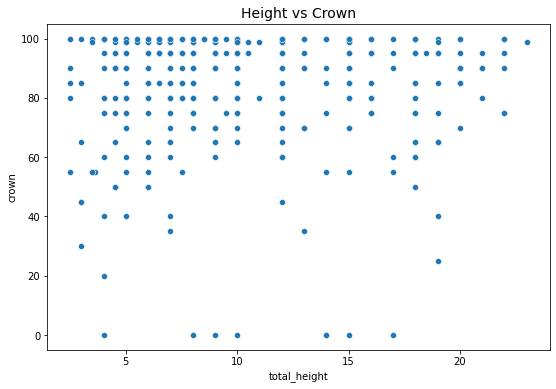

In [8]:
sql="""
select total_height,crown_condition
,cast(case 
        when instr(crown_condition,'-')>0 then substr(crown_condition,instr(crown_condition,'-')+2,2)
        else substr(crown_condition,1,3)
        end as float) as crown
from LG_06_data
    ;
"""

df_height_crown=pd.read_sql(sql,con)

plt.figure(figsize=(9,6))
sns.scatterplot(y='crown',x="total_height",data=df_height_crown)
# plt.xlim(55,105)
plt.title("Height vs Crown",fontsize=14)

It seems that the relationship between this two is unclear. I think the height might be more related to its specie. In fact, tree height is also an important indicator of tree biomass calculation, because carbon sequestration is linearly related to tree volume. However, the current can not draw more conclusions. If it is necessary to further obtain the influence of trees, it is also necessary to combine tree species to find some trees that are easier to grow tall. 

My analysis of crown in this assignment is more based on carbon sequestration, because it is directly related to the biomass of the tree. I didn't analyze the possibility of carbon dioxide absorption, because we don't have data on carbon dioxide absorption and emission, and there is also a lack of evidence related to tree crown and carbon dioxide absorption capacity. If I want to analyze this, I also need theoretical support and calculation formulas.

### Then I check the relation between crown and species.

In [9]:
# check species attribute.
sql="""
    select species,plot,count(*) as n_samples
    from LG_06_data
    group by species
    order by n_samples desc
    ;
"""
pd.read_sql(sql,con)

,species,plot,n_samples
0,Black locust (Robinia pseudoacacia),2,177
1,European hackberry (Celtis australis),1,150
2,Black poplar (Populus nigra),5,41
3,Field elm (Ulmus minor),1,39
4,European black elderberry (Sambucus nigra),1,29
5,Sweet cherry (Prunus avium),1,17
6,Tree of heaven (Ailanthus altissima),2,10
7,Oneseed hawthorn (Crataegus monogyna),4,7
8,White mulberry (Morus alba),6,6
9,Common fig (Ficus carica),16,5


,species,crown
0,European hackberry (Celtis australis),95.0
1,European hackberry (Celtis australis),75.0
2,European hackberry (Celtis australis),70.0
3,Sweet cherry (Prunus avium),100.0
4,Sweet cherry (Prunus avium),100.0
...,...,...
504,Black locust (Robinia pseudoacacia),100.0
505,White mulberry (Morus alba),100.0
506,Black locust (Robinia pseudoacacia),100.0
507,Black locust (Robinia pseudoacacia),100.0


Text(0.5, 1.0, 'Boxplot of Crown by Species')

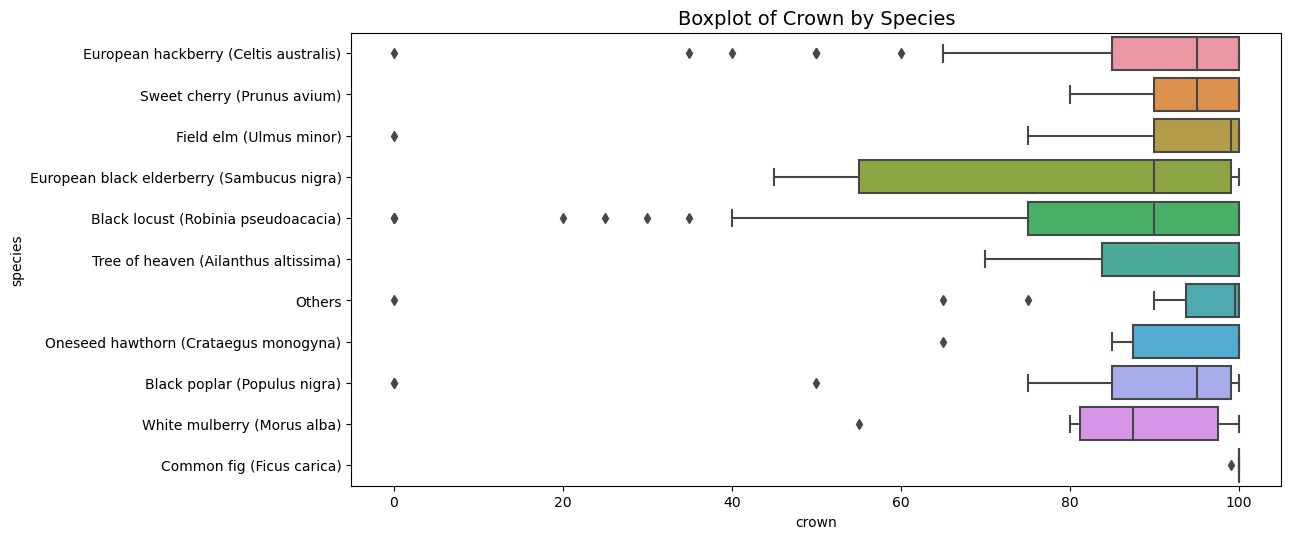

In [10]:
sql="""

select 
    case 
    when b.species is not null then a.species 
    else "Others" 
    end as species,a.crown
from 
(
    select species,crown_condition
    ,cast(case 
            when instr(crown_condition,'-')>0 then substr(crown_condition,instr(crown_condition,'-')+2,2)
            else substr(crown_condition,1,3)
            end as float) as crown
    from LG_06_data
) a
left join
(
    select case 
            when n_samples<5 then 'Others'
            else species
            end as species
            ,sum(n_samples) as n_samples
    from 
    (
        select species,count(*) as n_samples
        from LG_06_data
        group by species        
    )tmp
    group by 1
)b
on a.species=b.species

    ;
"""

df_species_crown=pd.read_sql(sql,con)
display(df_species_crown)

plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(y="species",x="crown",data=df_species_crown)
plt.title("Boxplot of Crown by Species",fontsize=14)

Text(0.5, 1.0, 'Average Crown by Species')

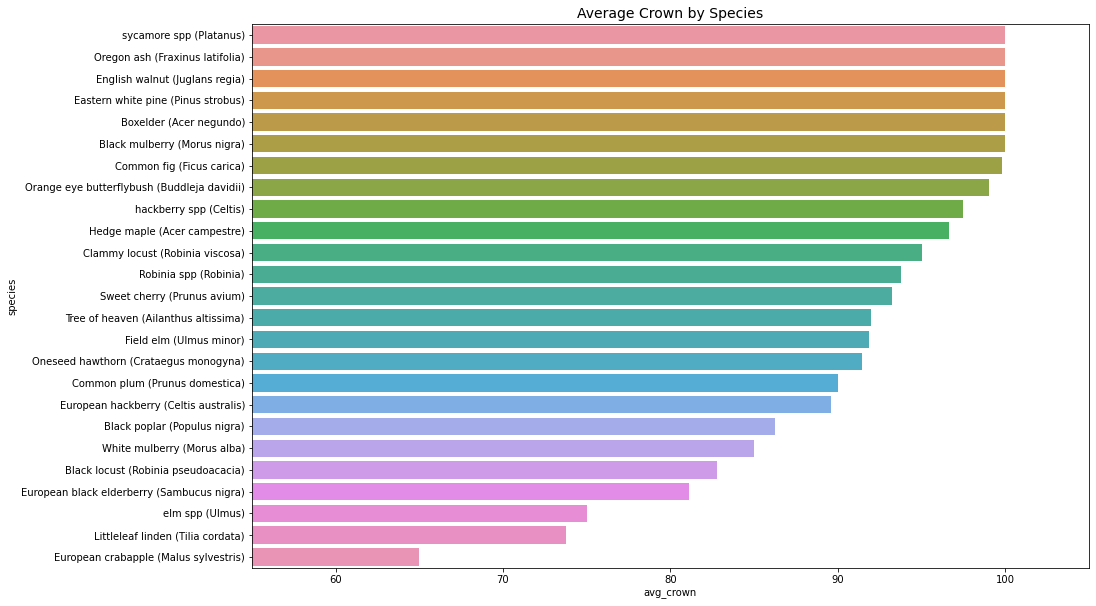

In [11]:
# The original crown is a string. In order to calculate the mean value, I take the upper limit of each interval as the crown
# i.e. 90% - 95% is regarded as 95%

#The section"when case"is to get the last value from the strings
sql="""
select species,avg(crown) as avg_crown
from 
(
    select species,crown_condition
    ,cast(case 
            when instr(crown_condition,'-')>0 then substr(crown_condition,instr(crown_condition,'-')+2,2)
            else substr(crown_condition,1,3)
            end as float) as crown
    from LG_06_data
) tmp 
    group by species
    order by avg_crown desc
    ;
"""

df_species_crown=pd.read_sql(sql,con)

plt.figure(figsize=(15,10))
sns.barplot(y='species',x="avg_crown",data=df_species_crown)
plt.xlim(55,105)
plt.title("Average Crown by Species",fontsize=14)

It seems that species has some influence on crown condition. But further analysis need to link to the height and dbh, to see it is casued by species that some species are easier to grow or it is just because some trees were planted eariler. 

### Take tree species information into account in plot.

In [ ]:
sql="""

select species,plot,count(*) as n_samples
from lg_06_data
group by species,plot
order by species,count(*) desc

"""

df_plot_species_dist=pd.read_sql(sql,con).pivot_table(index="species",columns="plot",values="n_samples")

# find the percentage of each species in each plot.
df_plot_species_dist=df_plot_species_dist.div(df_plot_species_dist.sum())
# display(df_plot_species_dist)

plt.figure(figsize=(15,10))
sns.heatmap(df_plot_species_dist, 
            annot=True, 
            linewidth=.2, 
            fmt="0.0%",
            cmap="YlGnBu")

_= plt.xticks(fontsize=12)
_= plt.yticks(fontsize=12)
plt.title("Species Distribution(in percentage) by Plot",fontsize=20)